In [44]:
# Make sure that you have all these libaries available to run the code successfully
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

# Downloading Data

In [45]:
import quandl
quandl.ApiConfig.api_key = 'iySJadzpPxtynZzTVVzu'
df = quandl.get_table('WIKI/PRICES', ticker = ['AAPL'], 
                        qopts = { 'columns': ['ticker', 'date', 'open','high','low','close'] }, 
                        date = { 'gte': '2004-01-01', 'lte': '2018-10-01' }, 
                        paginate=True)
# df = pd.read_csv('hpq.us.txt',delimiter=',',usecols=['Date','Open','High','Low','Close'])
# print('Loaded data from the Kaggle repository')
# print(data)
df = df.sort_values('date')
# data.head()
len(df)

3581

# Data Visualization

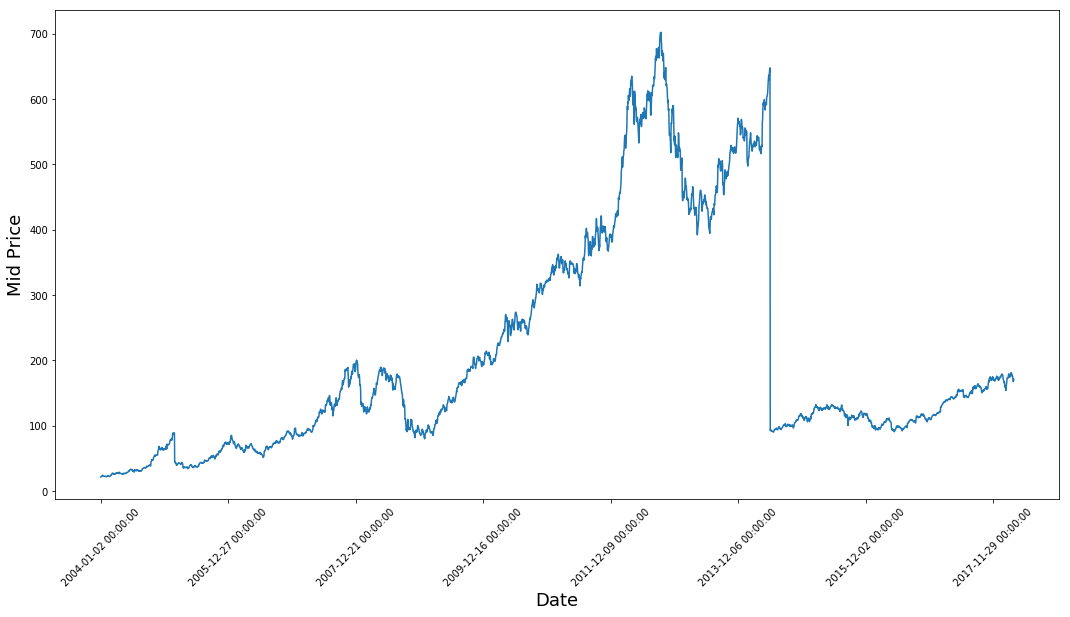

In [46]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

# Splitting the Dataset

In [47]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'high'].as_matrix()
low_prices = df.loc[:,'low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

train_data = mid_prices[:3000]
test_data = mid_prices[3000:]
print(train_data)

[ 21.465  21.905  22.065 ... 118.005 118.58  117.835]


/Users/cindy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/Users/cindy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


# Normalizing the Dataset

In [48]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
type(train_data)
print(train_data)
print(train_data.shape)
# print(train_data[1:51:1])
# test_data

[[ 21.465]
 [ 21.905]
 [ 22.065]
 ...
 [118.005]
 [118.58 ]
 [117.835]]
(3000, 1)


In [163]:
# data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
data=np.ones((4,1))
# data[0,1]=2
# data[1,0]=3
# data[1,1]=4
# print(data)
scaler = MinMaxScaler()
# print(data[1:3,:])
# print(train_data[4950:4950+50,:])

# for di in range(0,41,20):
#     print(di)

In [49]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 1000
for di in range(0,2000,smoothing_window_size):
#     print(di,di+smoothing_window_size)
    scaler.fit(train_data[di:di+smoothing_window_size,:])
#     print(yes)
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

print(train_data)

[0.         0.00253888 0.0034621  ... 0.04547082 0.0464103  0.04519306]


In [ ]:
[0.16075614 0.1852552  0.20695652 ... 0.075451   0.0746946  0.07632087]

In [50]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(3000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
print(train_data.shape)
print(test_data.shape)
all_mid_data = np.concatenate([train_data,test_data],axis=0)

(3000,)
(581,)


In [51]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00830


3581
3000
2900
3581
2900


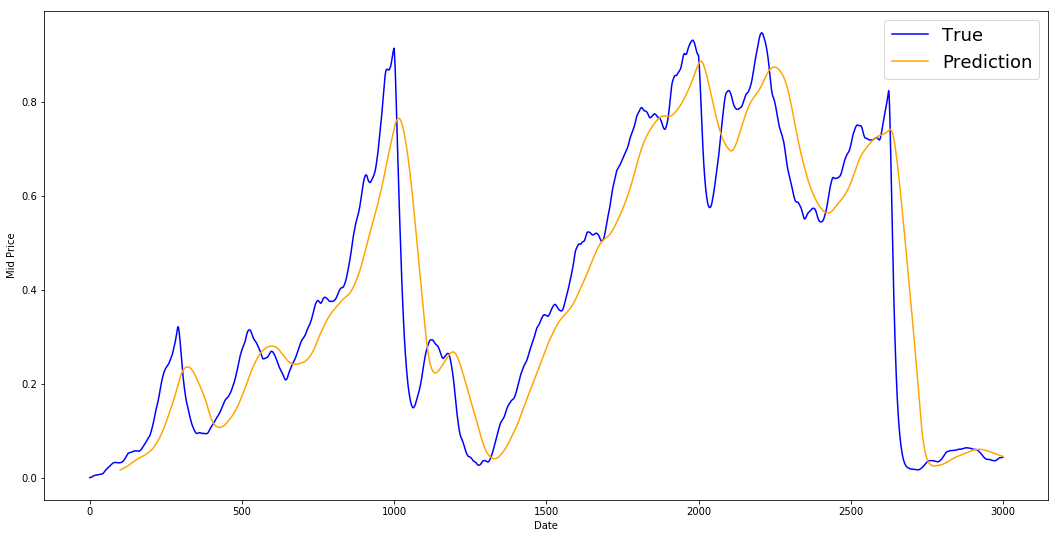

In [23]:
plt.figure(figsize = (18,9))
# print(all_mid_data.shape)
# # print(df.shape[0])
# print(df.shape[0])
# print(len(train_data))
# print(len(std_avg_predictions))

plt.plot(range(train_data.shape[0]),train_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')

# print(len(all_mid_data))
# print(len(std_avg_predictions))
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [52]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00006


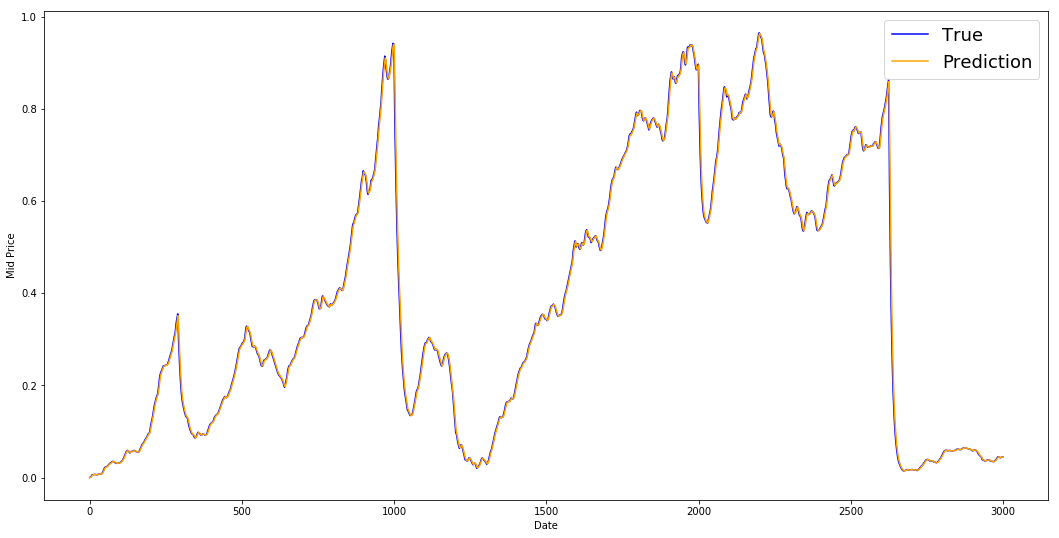

In [53]:
plt.figure(figsize = (18,9))
plt.plot(range(train_data.shape[0]),train_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [54]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.         0.26650423 0.13043898 0.7900487  0.5373099 ]

	Output: [0.         0.25824243 0.09796282 0.7900487  0.5385466 ]


Unrolled index 1
	Inputs:  [2.5388764e-04 2.6403949e-01 1.2182771e-01 7.8768796e-01 5.3854662e-01]

	Output: [5.7470932e-04 2.6403949e-01 9.5691003e-02 7.8514904e-01 5.3854662e-01]


Unrolled index 2
	Inputs:  [5.74709324e-04 2.62233794e-01 1.12840824e-01 7.85602808e-01
 5.39909661e-01]

	Output: [0.00380731 0.2622338  0.09796282 0.78831446 0.5451699 ]


Unrolled index 3
	Inputs:  [0.00104521 0.2597489  0.10480978 0.78514904 0.5410237 ]

	Output: [0.00289359 0.25687507 0.09481718 0.78831446 0.5451699 ]


Unrolled index 4
	Inputs:  [0.00193604 0.25824243 0.09796282 0.78663677 0.5424805 ]

	Output: [0.00380731 0.25824243 0.09796282 0.78757    0.5451699 ]


In [55]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [56]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [41]:
shape=[num_nodes[-1], 1]
print(shape)

[150, 1]


In [57]:
## Creation of LSTM cells based on the number of hidden nodes in each layer
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

## Operator adding dropout to inputs and outputs of the given cell.

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

## Gets an existing variable with these parameters or create a new one.
w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [58]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transformation, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

## Computes matmul(x, weights) + biases.
all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [59]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error of each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0

## Wrapper for Graph.control_dependencies() using the default graph.

## Update 'ref' by assigning 'value' to it.

## This operation outputs a Tensor that holds the new value of 'ref' after the value has been assigned. 
## This makes it easier to chain operations that need to use the reset value.
## e.g. assign state[li][0] to c[li]

with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    ## Computes the mean of elements across dimensions of a tensor. (deprecated arguments)
    ## e.g. x = tf.constant([[1., 1.], [2., 2.]])
    ## tf.reduce_mean(x)  # 1.5
    ## tf.reduce_mean(x, 0)  # [1.5, 1.5]
    
    ## Calculates the difference between what is obtained from lstm and the actual train result
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [60]:
## Finally you calculate the prediction with the tf.nn.dynamic_rnn function 
## and then sending the output through the regression layer (w and b)
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


# Running the LSTM

In [40]:
print(np.arange(5000,8600,50).tolist())

print(5//2)

[5000, 5050, 5100, 5150, 5200, 5250, 5300, 5350, 5400, 5450, 5500, 5550, 5600, 5650, 5700, 5750, 5800, 5850, 5900, 5950, 6000, 6050, 6100, 6150, 6200, 6250, 6300, 6350, 6400, 6450, 6500, 6550, 6600, 6650, 6700, 6750, 6800, 6850, 6900, 6950, 7000, 7050, 7100, 7150, 7200, 7250, 7300, 7350, 7400, 7450, 7500, 7550, 7600, 7650, 7700, 7750, 7800, 7850, 7900, 7950, 8000, 8050, 8100, 8150, 8200, 8250, 8300, 8350, 8400, 8450, 8500, 8550]
2


In [43]:
yoyo=[1,2,3]
for i in enumerate(zip(yoyo)):
    print(i)

(0, (1,))
(1, (2,))
(2, (3,))


In [61]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(3000,3500,50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    ## Iterate through each batch
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediction as its current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

/Users/cindy/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 7.789665
	Test MSE: 0.00610
	Finished Predictions
Average loss at step 2: 3.737497
	Test MSE: 0.00181
	Finished Predictions
Average loss at step 3: 0.738198
	Test MSE: 0.00615
	Finished Predictions
Average loss at step 4: 0.638279
	Test MSE: 0.00040
	Finished Predictions
Average loss at step 5: 0.302324
	Test MSE: 0.00039
	Finished Predictions
Average loss at step 6: 0.274768
	Test MSE: 0.00251
	Finished Predictions
Average loss at step 7: 0.244334
	Test MSE: 0.00030
	Finished Predictions
Average loss at step 8: 0.199770
	Test MSE: 0.00140
	Finished Predictions
Average loss at step 9: 0.187237
	Test MSE: 0.00018
	Finished Predictions
Average loss at step 10: 0.147809
	Test MSE: 0.00057
	Finished Predictions
Average loss at step 11: 0.146743
	Test MSE: 0.00016
	Finished Predictions
Average loss at step 12: 0.158081
	Test MSE: 0.00033
	Finished Predictions
Average loss at step 13: 0.149347
	Test MSE: 0.00016
	Finished Predictions
Average loss at step 1

# From when dataset is from date = { 'gte': '2004-01-01', 'lte': '2018-10-01' },
train_data is of size 3000 and the test data is roughly 3581-3000, and the prediction starts at 3000 and ends at 3400

Initialized
Average loss at step 1: 4.114176
	Test MSE: 6847.38135
	Finished Predictions
Average loss at step 2: 1.569747
	Test MSE: 6745.64307
	Finished Predictions
Average loss at step 3: 0.616816
	Test MSE: 6663.85205
	Finished Predictions
Average loss at step 4: 0.597345
	Test MSE: 6714.64355
	Finished Predictions
Average loss at step 5: 0.276088
	Test MSE: 6698.48340
	Finished Predictions
Average loss at step 6: 0.252348
	Decreasing learning rate by 0.5
	Test MSE: 6665.29980
	Finished Predictions
Average loss at step 7: 0.217247
	Test MSE: 6681.42041
	Finished Predictions
Average loss at step 8: 0.179715
	Test MSE: 6673.56787
	Finished Predictions
Average loss at step 9: 0.159827
	Test MSE: 6648.94238
	Finished Predictions
Average loss at step 10: 0.128842
	Test MSE: 6640.13574
	Finished Predictions
Average loss at step 11: 0.117934
	Test MSE: 6632.72607
	Finished Predictions
Average loss at step 12: 0.125738
	Test MSE: 6616.81348
	Finished Predictions
Average loss at step 13: 0.129549
	Test MSE: 6613.13086
	Finished Predictions
Average loss at step 14: 0.120044
	Test MSE: 6601.04980
	Finished Predictions
Average loss at step 15: 0.108862
	Test MSE: 6594.54980
	Finished Predictions
Average loss at step 16: 0.110721
	Test MSE: 6590.32812
	Finished Predictions
Average loss at step 17: 0.111839
	Test MSE: 6581.57373
	Finished Predictions
Average loss at step 18: 0.101522
	Test MSE: 6578.26025
	Finished Predictions
Average loss at step 19: 0.092125
	Test MSE: 6565.39746
	Finished Predictions
Average loss at step 20: 0.078488
	Test MSE: 6561.14160
	Finished Predictions
Average loss at step 21: 0.085171
	Test MSE: 6549.94482
	Finished Predictions
Average loss at step 22: 0.086508
	Test MSE: 6546.57422
	Finished Predictions
Average loss at step 23: 0.092450
	Test MSE: 6538.24414
	Finished Predictions
Average loss at step 24: 0.082285
	Test MSE: 6525.52100
	Finished Predictions
Average loss at step 25: 0.083723
	Test MSE: 6518.63672
	Finished Predictions
Average loss at step 26: 0.075408
	Test MSE: 6508.43457
	Finished Predictions
Average loss at step 27: 0.073625
	Test MSE: 6498.32373
	Finished Predictions
Average loss at step 28: 0.073862
	Test MSE: 6494.61035
	Finished Predictions
Average loss at step 29: 0.066515
	Test MSE: 6481.49902
	Finished Predictions
Average loss at step 30: 0.062816
	Test MSE: 6474.32178
	Finished Predictio

Initialized
Average loss at step 1: 7.789665
	Test MSE: 0.00610
	Finished Predictions
Average loss at step 2: 3.737497
	Test MSE: 0.00181
	Finished Predictions
Average loss at step 3: 0.738198
	Test MSE: 0.00615
	Finished Predictions
Average loss at step 4: 0.638279
	Test MSE: 0.00040
	Finished Predictions
Average loss at step 5: 0.302324
	Test MSE: 0.00039
	Finished Predictions
Average loss at step 6: 0.274768
	Test MSE: 0.00251
	Finished Predictions
Average loss at step 7: 0.244334
	Test MSE: 0.00030
	Finished Predictions
Average loss at step 8: 0.199770
	Test MSE: 0.00140
	Finished Predictions
Average loss at step 9: 0.187237
	Test MSE: 0.00018
	Finished Predictions
Average loss at step 10: 0.147809
	Test MSE: 0.00057
	Finished Predictions
Average loss at step 11: 0.146743
	Test MSE: 0.00016
	Finished Predictions
Average loss at step 12: 0.158081
	Test MSE: 0.00033
	Finished Predictions
Average loss at step 13: 0.149347
	Test MSE: 0.00016
	Finished Predictions
Average loss at step 14: 0.131514
	Decreasing learning rate by 0.5
	Test MSE: 0.00033
	Finished Predictions
Average loss at step 15: 0.137309
	Test MSE: 0.00023
	Finished Predictions
Average loss at step 16: 0.131875
	Test MSE: 0.00035
	Finished Predictions
Average loss at step 17: 0.133408
	Decreasing learning rate by 0.5
	Test MSE: 0.00024
	Finished Predictions
Average loss at step 18: 0.123691
	Test MSE: 0.00031
	Finished Predictions
Average loss at step 19: 0.118915
	Test MSE: 0.00030
	Finished Predictions
Average loss at step 20: 0.108819
	Decreasing learning rate by 0.5
	Test MSE: 0.00029
	Finished Predictions
Average loss at step 21: 0.109480
	Test MSE: 0.00031
	Finished Predictions
Average loss at step 22: 0.116023
	Test MSE: 0.00036
	Finished Predictions
Average loss at step 23: 0.118099
	Decreasing learning rate by 0.5
	Test MSE: 0.00035
	Finished Predictions
Average loss at step 24: 0.112904
	Test MSE: 0.00033
	Finished Predictions
Average loss at step 25: 0.125279
	Test MSE: 0.00033
	Finished Predictions
Average loss at step 26: 0.124272
	Decreasing learning rate by 0.5
	Test MSE: 0.00033
	Finished Predictions
Average loss at step 27: 0.114009
	Test MSE: 0.00032
	Finished Predictions
Average loss at step 28: 0.112077
	Test MSE: 0.00031
	Finished Predictions
Average loss at step 29: 0.111082
	Decreasing learning rate by 0.5
	Test MSE: 0.00031
	Finished Predictions
Average loss at step 30: 0.102530
	Test MSE: 0.00032
	Finished Predictions

3581


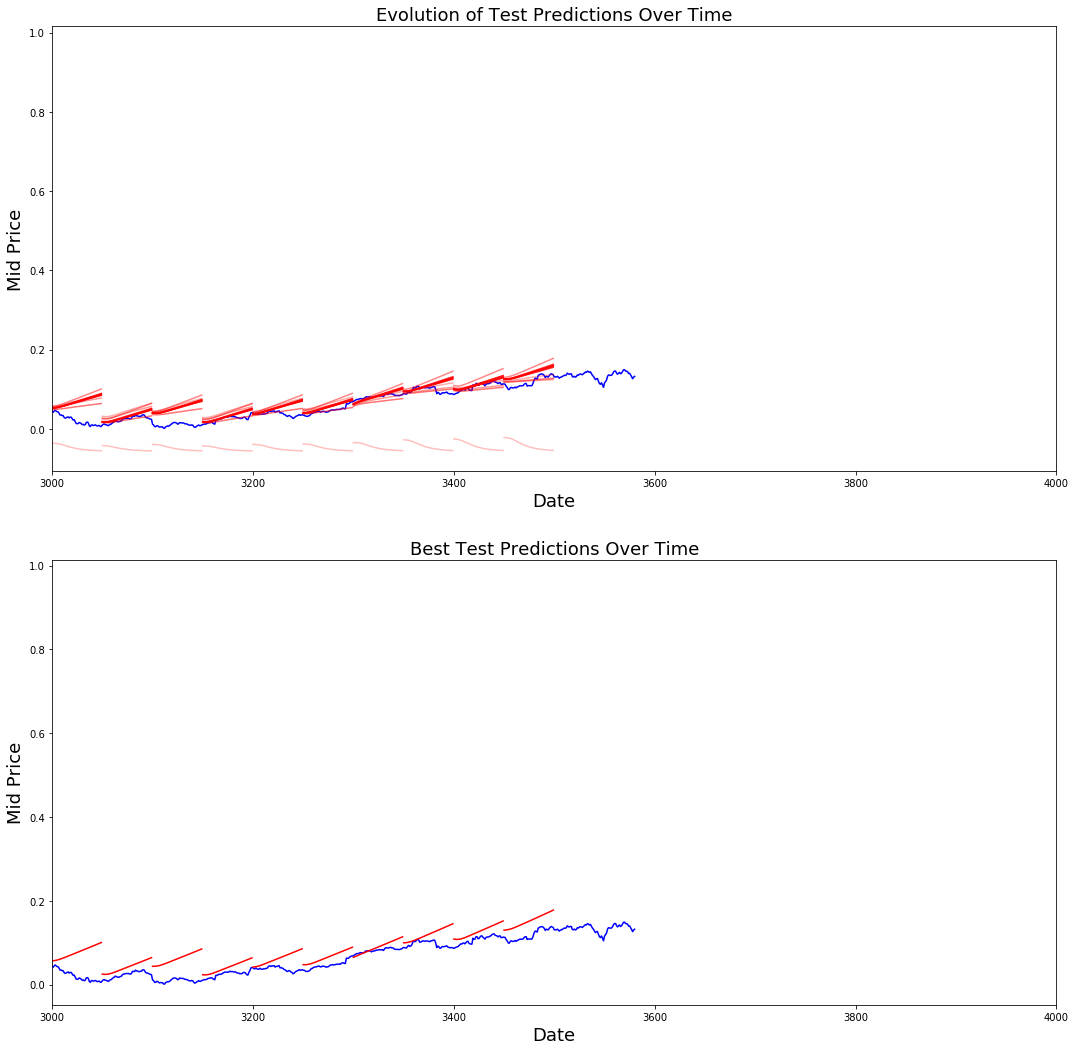

In [66]:
best_prediction_epoch = 9 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
print(df.shape[0])
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(3000,4000)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(3000,4000)
plt.show()